# Skipgrams over Skipgrams

## Setup

In [1]:
# addprocs([("chfin-tp", :auto)])
# addprocs()

In [2]:
using DigitalMusicology

In [3]:
@everywhere DigitalMusicology.usekern("/home/chfin/Uni/phd/data/csapp/mozart-piano-sonatas/");

In [4]:
# contains the "skipgrams over skipgrams" code
@everywhere include("skipgrams.jl");
using Unsims

## Analyzing a piece

In [5]:
prinnerpiece = "sonata03-2"
notes = getpiece(prinnerpiece, :notes_secs);

The notes are grouped to non-simultaneous note groups ("unsims")

In [6]:
mozunsims = unsims(notes, 1.0, 2, 1.0);

Unsims are again grouped to skipgrams.
Output skipgrams are sampled with `p = 0.00001`.

In [37]:
sgs = unsimskipgrams(mozunsims, 1.0, 4, 0.01);

The resulting SG^2s are reduced to their pitch content (notes -> pitches),
each group is sorted by ascending pitch,
pitches are trasposed relative to the first pitch in the first group (reference pitch)
and converted to pitch classes (`schemacandify`).
This allows to reproduce, which pc appeared in which voice, relative to the reference note.

The resulting "schema candidates" are counted (with equal weights for now):

In [38]:
counts = countmapby(sgs, schemacandify);

The counted schema candidates are ranked by their counts.

In [39]:
ranks = rankcounts(counts)
topranks(ranks, 100);

320.0: [0, 5] -> [10, 2] -> [5, 7] -> [0, 5]
277.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
275.0: [0, 5] -> [9, 9] -> [0, 5] -> [5, 5]
266.0: [0, 4] -> [0, 4] -> [4, 7] -> [0, 0]
264.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
254.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
249.0: [0, 5] -> [2, 5] -> [5, 7] -> [0, 5]
233.0: [0, 4] -> [0, 7] -> [4, 7] -> [0, 0]
228.0: [0, 0] -> [5, 0] -> [9, 0] -> [7, 0]
227.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
226.0: [0, 8] -> [1, 8] -> [5, 10] -> [3, 8]
226.0: [0, 5] -> [9, 0] -> [0, 5] -> [5, 5]
224.0: [0, 5] -> [10, 2] -> [2, 5] -> [0, 5]
223.0: [0, 0] -> [5, 0] -> [9, 2] -> [7, 0]
222.0: [0, 5] -> [0, 5] -> [9, 9] -> [0, 5]
222.0: [0, 0] -> [5, 9] -> [0, 2] -> [7, 0]
216.0: [0, 5] -> [5, 9] -> [0, 0] -> [5, 5]
215.0: [0, 5] -> [5, 9] -> [0, 5] -> [5, 5]
215.0: [0, 5] -> [0, 5] -> [5, 9] -> [0, 5]
214.0: [0, 8] -> [1, 8] -> [8, 10] -> [3, 8]
208.0: [0, 5] -> [0, 5] -> [10, 5] -> [0, 5]
208.0: [0, 5] -> [10, 2] -> [0, 5] -> [0, 5]
208.0: [0, 4] -> [4, 0

As the schema candidates are dominated by artifacts (trills?), it is necessary to filter out the problematic cases.

In [40]:
# trill
istrill(cand) =
    all(stage -> all(p -> p==midi(2) || p==midi(0), stage), cand) ||
    all(stage -> all(p -> p==midi(10) || p==midi(0), stage), cand)

notrills = filter(r -> !istrill(r[1]), ranks)
topranks(notrills, 20)

320.0: [0, 5] -> [10, 2] -> [5, 7] -> [0, 5]
277.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
275.0: [0, 5] -> [9, 9] -> [0, 5] -> [5, 5]
266.0: [0, 4] -> [0, 4] -> [4, 7] -> [0, 0]
264.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
254.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
249.0: [0, 5] -> [2, 5] -> [5, 7] -> [0, 5]
233.0: [0, 4] -> [0, 7] -> [4, 7] -> [0, 0]
228.0: [0, 0] -> [5, 0] -> [9, 0] -> [7, 0]
227.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
226.0: [0, 8] -> [1, 8] -> [5, 10] -> [3, 8]
226.0: [0, 5] -> [9, 0] -> [0, 5] -> [5, 5]
224.0: [0, 5] -> [10, 2] -> [2, 5] -> [0, 5]
223.0: [0, 0] -> [5, 0] -> [9, 2] -> [7, 0]
222.0: [0, 5] -> [0, 5] -> [9, 9] -> [0, 5]
222.0: [0, 0] -> [5, 9] -> [0, 2] -> [7, 0]
216.0: [0, 5] -> [5, 9] -> [0, 0] -> [5, 5]
215.0: [0, 5] -> [5, 9] -> [0, 5] -> [5, 5]
215.0: [0, 5] -> [0, 5] -> [5, 9] -> [0, 5]
214.0: [0, 8] -> [1, 8] -> [8, 10] -> [3, 8]


In [41]:
# trill part
istrillpart(cand) =
    any(midis(0:11)) do trans
        count(stage -> all(p -> pc(p+trans) ∈ [midi(0), midi(2)], stage), cand) > 1
    end

notrillparts = filter(r -> !istrillpart(r[1]), notrills)
topranks(notrillparts, 20)

320.0: [0, 5] -> [10, 2] -> [5, 7] -> [0, 5]
277.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
275.0: [0, 5] -> [9, 9] -> [0, 5] -> [5, 5]
266.0: [0, 4] -> [0, 4] -> [4, 7] -> [0, 0]
264.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
254.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
249.0: [0, 5] -> [2, 5] -> [5, 7] -> [0, 5]
233.0: [0, 4] -> [0, 7] -> [4, 7] -> [0, 0]
228.0: [0, 0] -> [5, 0] -> [9, 0] -> [7, 0]
227.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
226.0: [0, 8] -> [1, 8] -> [5, 10] -> [3, 8]
226.0: [0, 5] -> [9, 0] -> [0, 5] -> [5, 5]
224.0: [0, 5] -> [10, 2] -> [2, 5] -> [0, 5]
223.0: [0, 0] -> [5, 0] -> [9, 2] -> [7, 0]
222.0: [0, 5] -> [0, 5] -> [9, 9] -> [0, 5]
216.0: [0, 5] -> [5, 9] -> [0, 0] -> [5, 5]
215.0: [0, 5] -> [5, 9] -> [0, 5] -> [5, 5]
215.0: [0, 5] -> [0, 5] -> [5, 9] -> [0, 5]
214.0: [0, 8] -> [1, 8] -> [8, 10] -> [3, 8]
208.0: [0, 5] -> [0, 5] -> [10, 5] -> [0, 5]


In [42]:
#fst = Unsims.findfirstusg(mozunsims, map(midis, [[0,4], [0,4], [0,5], [0,0]]), 1.0, 4, 1)
fst = Unsims.findfirstusg(mozunsims, notrillparts[1][1], 1.0, 4, 1)

4-element Array{Array{DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64},1},1}:
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<0.4166665-0.833333>(82), Note<0.833333-1.2499995>(77)]         
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<1.2499995-1.666666>(79), Note<1.2499995-1.666666>(75)]         
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<2.0833325-2.499999>(72), Note<2.499999-2.9166654999999997>(70)]
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<3.333332-3.7499985>(70), Note<3.7499985-4.166665>(65)]         

In [43]:
schemacandify(fst)

4-element Array{Array{DigitalMusicology.Pitches.MidiPitch,1},1}:
 DigitalMusicology.Pitches.MidiPitch[0, 5] 
 DigitalMusicology.Pitches.MidiPitch[10, 2]
 DigitalMusicology.Pitches.MidiPitch[5, 7] 
 DigitalMusicology.Pitches.MidiPitch[0, 5] 

In [46]:
using Plots
using MusicologyPlots
gr()

Plots.GRBackend()

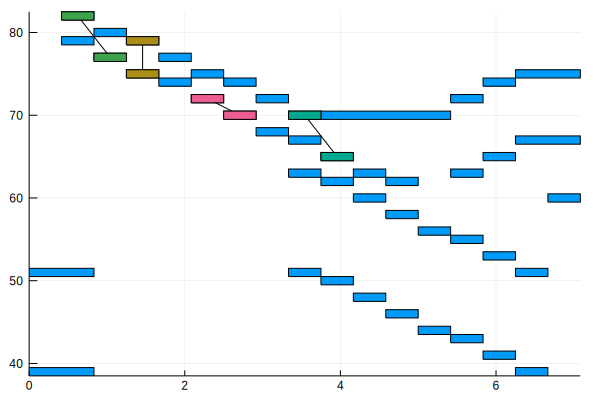

In [51]:
lower = onset(fst[1][1])
upper = maximum(map(offset, fst[4]))
isinrange(n) = onset(n) > lower-3.0 && offset(n) < upper+3.0
pianoroll(filter(isinrange, notes), legend=false, fmt=:svg)
plotschema!(fst)

In [56]:
savefig("skipgram_plot.pdf")